# Build an avatar with ASR, Sentence-transformer, Similarity Search, TTS and Omniverse Audio2Face

I’ll show you how I used several Python packages and NVIDIA’s Omniverse Audio2Face to quickly implement an avatar that can answer questions defined in a knowledge set or FAQ.

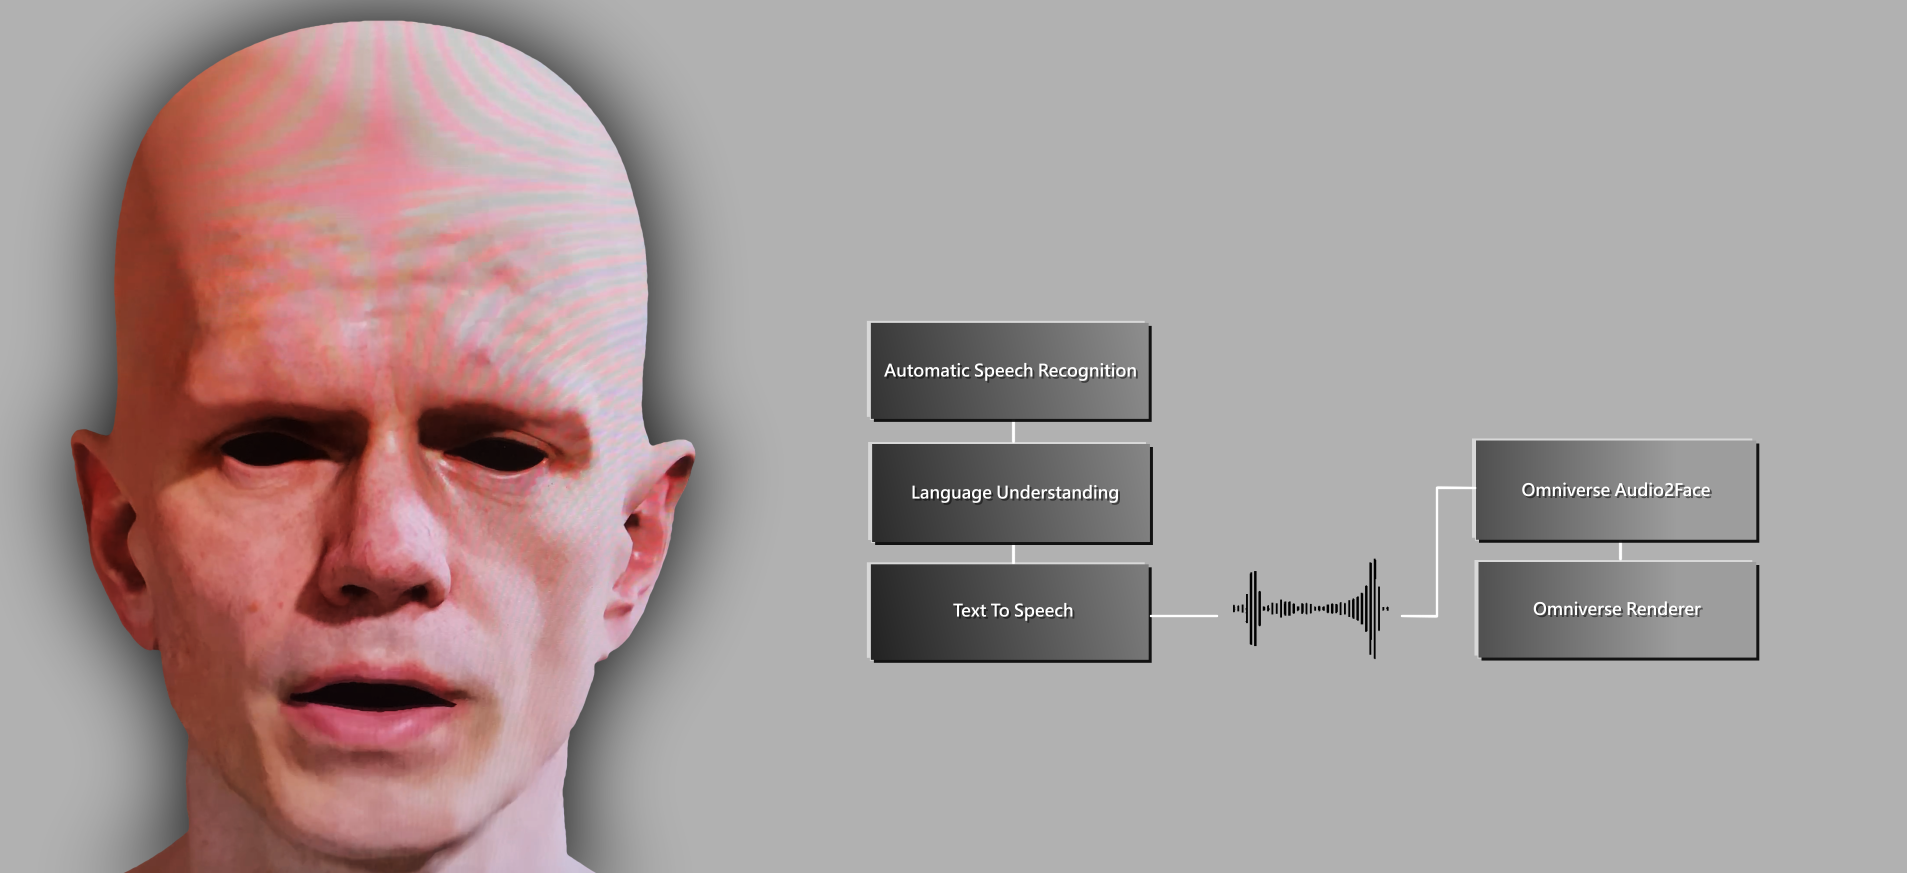

## Import libraries

In [1]:
import time
import re
import io

import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer, util
import faiss 

import speech_recognition as sr
from gtts import gTTS

from pydub import AudioSegment
from scipy.io.wavfile import read, write

import audio2face_pb2
import audio2face_pb2_grpc

import grpc
from audio2face_streaming_utils import push_audio_track

## 1. Create Custom Dataset for Question Answering
We use the <a href='https://github.com/zake7749/Gossiping-Chinese-Corpus'>Gossiping-Chinese-Corpus</a> as the question answering dataset, because it contains a total of 774,114 question-answer pairs on different topics. ***You can use a custom dataset instead if you like.***

### 1-1. Load Dataset

In [2]:
qa_data_2 = pd.read_csv('data/Gossiping-QA-Dataset-2_0-non-null.csv')
qa_data_2 = qa_data_2.dropna()
qa_data_2.head()

,question,answer
0,為什麼 聖結石 會被酸而 這群人 不會,質感 劇本 成員 都差很多好嗎 不要拿腎結石來污辱這群人
1,為什麼慶祝228會被罵可是慶端午不會,因為屈原不是台灣人是楚國人
2,有沒有戰神阿瑞斯的八卦,爵士就是阿瑞斯 男主角最後死了
3,理論與實務最脫節的系,哪個系不脫節你問最不脫節的簡單多了
4,為什麼PTT這麼多人看棒球,肥宅才看棒球 系壘一堆胖子


### 1-2. Preprocessing
The purpose is to remove emoticons in the sentences.

In [3]:
qa_data_2['question'] = qa_data_2.question.str.replace('[^\w\s]','')
qa_data_2['answer'] = qa_data_2.answer.str.replace('[^\w\s]','')

C:\Users\rt\AppData\Local\Temp\ipykernel_17284\3105126424.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  qa_data_2['question'] = qa_data_2.question.str.replace('[^\w\s]','')
C:\Users\rt\AppData\Local\Temp\ipykernel_17284\3105126424.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qa_data_2['answer'] = qa_data_2.answer.str.replace('[^\w\s]','')


### 1-3. Sentence-Transformer
<a href='https://www.sbert.net/'>Sentence-Transformer</a> is for state-of-the-art sentence, text and image embeddings that can encode sentence into feature vectors. The feature vectors represent entire sentences and their semantic information, this helps the machine in understanding the context, intention, and other nuances in the entire text. 

In [4]:
#This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space 
#and can be used for tasks like clustering or semantic search.
model = SentenceTransformer('paraphrase-xlm-r-multilingual-v1') 

### 1-4. Sentence Embedding For The Question Answering Task

In [5]:
sentence_embedded = model.encode(qa_data_2.question.values) #Encode all questions in the dataset into feature vectors
print(sentence_embedded.shape)

# Save the feature vectors as .npy file
with open('./sentence_2_vector/sentence_embedded.npy', 'wb') as f:
    np.save(f, sentence_embedded)

(774056, 768)


In [6]:
# Load feature vectors 
with open('./sentence_2_vector/sentence_embedded.npy', 'rb') as f:
    sentence_embedded = np.load(f)

## 2. Faiss For Semantic Search
We’ll conduct a similarity search, comparing a user input question to a list of FAQs and return the most likely answers by <a href='https://ai.facebook.com/tools/faiss'>Facebook’s Similarity Search API</a>. 
See <a href='https://www.programcreek.com/python/example/112282/faiss.IndexFlatL2'>examples</a> how to use Faiss.

In [7]:
d = sentence_embedded.shape[1]  # The length of each feature vector
nb = sentence_embedded.shape[0] # Number of dataset records
nq = 1 # Number of query
index = faiss.IndexFlatL2(d)       
index.add(sentence_embedded)

## 3. Helper Functions

In [8]:
asr=sr.Recognizer()

def get_str_answer(str_question, top_k=5):
    """
    The function conducts a semantic similarity search, randomly selects one of the most likely questions, 
    and uses its corresponding answer as the final answer.
    Parameters:
     * str_question: string, containing user input question
    """
    global model
    global index
    global qa_data_2
    
    input_question = model.encode([str_question])
    D, I = index.search(input_question, top_k)
    return qa_data_2.iloc[I[0]].sample().answer.values[0]

def speech_to_text(audio):
    global asr
    try:
        return True, asr.recognize_google(audio, language="zh-TW")
    except Exception as e:
        return False, e.__class__

def answer(str_question):
    str_response = get_str_answer(str_question)
    make_avatar_speaks(str_response)
    return 

def get_tts_data(text):
    tts_result = io.BytesIO()
    tts = gTTS(text=text, lang='zh-TW', slow=False)
    tts.write_to_fp(tts_result)
    tts_result.seek(0)
    return tts_result.read()

def tts_to_wav(tts_byte, framerate=22050):
    seg=AudioSegment.from_mp3(io.BytesIO(tts_byte))
    seg=seg.set_frame_rate(framerate)
    seg=seg.set_channels(1)
    wavIO=io.BytesIO()
    seg.export(wavIO, format="wav")
    rate, wav = read(io.BytesIO(wavIO.getvalue()))
    return wav

def wav_to_numpy_float32(wav_byte):
    return wav_byte.astype(np.float32, order='C') / 32768.0

def get_tts_numpy_audio(text):
    mp3_byte = get_tts_data(text)
    wav_byte = tts_to_wav(mp3_byte)
    return wav_to_numpy_float32(wav_byte)

def make_avatar_speaks(text):
    global a2f_url
    global sample_rate
    global a2f_avatar_instance
    push_audio_track(a2f_url, get_tts_numpy_audio(text), sample_rate, a2f_avatar_instance)
    return 

## Avatar demo
***Make sure Omniverse audio2face is running in streaming mode to interact with our program.***

<iframe
  src="https://carbon.now.sh/embed?bg=rgba%28171%2C+184%2C+195%2C+1%29&t=seti&wt=none&l=auto&ds=true&dsyoff=20px&dsblur=68px&wc=true&wa=true&pv=56px&ph=56px&ln=false&fl=1&fm=Hack&fs=14px&lh=133%25&si=false&es=2x&wm=false&code=from%2520IPython.display%2520import%2520YouTubeVideo%250A%2523%2520YouTubeVideo%28id%252C%2520with%252C%2520height%252C%2520start%2520%253D%2520start_time%29%250AYouTubeVideo%28id%2520%253D%2520%271j_HxD4iLn8%27%252C%2520width%253D400%252C%2520height%253D300%252C%2520start%2520%253D%252020%29"
  style="width: 715px; height: 242px; border:0; transform: scale(1); overflow:hidden;"
  sandbox="allow-scripts allow-same-origin">
</iframe>

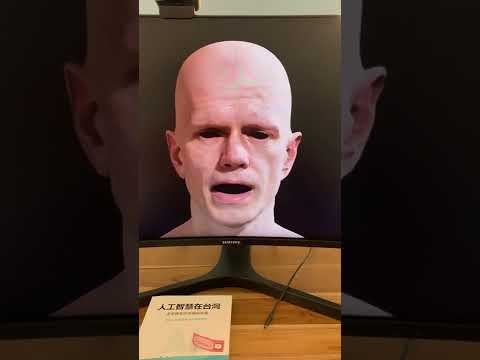

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('G_c94cGIKgs')

### Talk to your avatar

In [10]:
a2f_url = 'localhost:50051' # The audio2face url by default
sample_rate = 22050 # Audio frame rate
a2f_avatar_instance = '/audio2face/player_instance' # The instance name of the avatar in a2f

In [13]:
with sr.Microphone() as source:
    asr.adjust_for_ambient_noise(source, duration=5)
    print('Say something')
    audio=asr.listen(source)
    is_valid_input, _input = speech_to_text(audio)
    if is_valid_input:
            answer(_input)
    else:
        if _input is sr.UnknownValueError:
            make_avatar_speaks('Sorry, I could not hear what you said.')
        elif _input is sr.RequestError:
            print("No response from Google Speech Recognition service: {0}".format(_input))

Say something
Sending audio data...
SUCCESS
Closed channel
